<a href="https://colab.research.google.com/github/filipeverrone/Facial-Expression-Recognition-with-PyTorch/blob/main/Facial_Expression_Recognition_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Course Facial Expression Recognition with PyTorch on Coursera

# Dataset available at kaggle 

https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

# Install libraries, packages and datasets

In [64]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

fatal: destination path 'Facial-Expression-Dataset' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-q7czvj7l
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-q7czvj7l
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 

# Configurations

In [3]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train/'
VALID_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/validation/'

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15

DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b0'

# Load Dataset

In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T 

In [5]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor() # PIL / numpy arr -> torch tensor -> (h, w, c) -> (c, h, w)
])

valid_augs = T.Compose([
    T.ToTensor()
])

In [6]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform = valid_augs)

In [7]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [8]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [9]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '0')

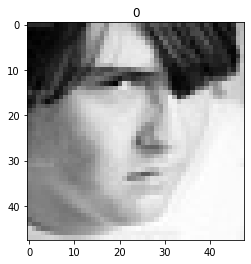

In [10]:
image, label = validset[40]

plt.imshow(image.permute(1, 2, 0)) # (h, w, c)
plt.title(label)

# Load dataset into batches

In [11]:
from torch.utils.data import DataLoader

In [12]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(trainset, batch_size = BATCH_SIZE)

In [13]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 901


In [14]:
for images, labels in trainloader:
    break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model

In [15]:
import timm
from torch import nn 

In [16]:
class FaceModel(nn.Module):

    def __init__(self):
        super(FaceModel, self).__init__()

        self.eff_net = timm.create_model(
            'efficientnet_b0',
            pretrained = True,
            num_classes = 7
        )

    def forward(self, images, labels = None):
        logits = self.eff_net(images)

        if labels != None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return logits, loss

        return logits

In [17]:
model = FaceModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 

# Create train and eval function

In [18]:
from tqdm import tqdm

In [19]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [20]:
def train_fn(model, dataloader, optimizer, current_epo):
    model.train()
    total_loss = 0.
    total_acc = 0.
    tk = tqdm(
        dataloader,
        desc = 'EPOCH' + '[TRAIN]' + str(current_epo + 1) + '/' + str(EPOCHS)
    )

    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({
            'loss': '%6f' %float(total_loss / (t + 1)),
            'acc': '%6f' %float(total_acc / (t + 1)),
        })

    return total_loss / len(dataloader), total_acc / len(dataloader)

In [21]:
def eval_fn(model, dataloader, current_epo):
    model.eval()
    total_loss = 0.
    total_acc = 0.
    tk = tqdm(
        dataloader,
        desc = 'EPOCH' + '[TRAIN]' + str(current_epo + 1) + '/' + str(EPOCHS)
    )

    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        logits, loss = model(images, labels)

        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({
            'loss': '%6f' %float(total_loss / (t + 1)),
            'acc': '%6f' %float(total_acc / (t + 1)),
        })

    return total_loss / len(dataloader), total_acc / len(dataloader)

# Create training loop

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [25]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
    valid_loss, valid_acc = eval_fn(model, validloader, i)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best-weights.pt')
        print('SAVED-BEST-WEIGHTS')
        best_valid_loss = valid_loss

EPOCH[TRAIN]1/15: 100%|██████████| 901/901 [00:29<00:00, 30.24it/s, loss=1.173075, acc=0.557760]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]2/15: 100%|██████████| 901/901 [00:28<00:00, 31.44it/s, loss=1.120331, acc=0.574671]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]3/15: 100%|██████████| 901/901 [00:28<00:00, 31.42it/s, loss=1.084403, acc=0.588179]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]4/15: 100%|██████████| 901/901 [00:29<00:00, 30.84it/s, loss=1.033482, acc=0.617138]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]5/15: 100%|██████████| 901/901 [00:29<00:00, 30.55it/s, loss=0.991918, acc=0.629415]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]6/15: 100%|██████████| 901/901 [00:28<00:00, 31.30it/s, loss=0.981662, acc=0.631673]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]7/15: 100%|██████████| 901/901 [00:29<00:00, 30.93it/s, loss=0.943003, acc=0.648474]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]8/15: 100%|██████████| 901/901 [00:29<00:00, 30.95it/s, loss=0.915164, acc=0.660356]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]9/15: 100%|██████████| 901/901 [00:28<00:00, 31.57it/s, loss=0.866116, acc=0.678116]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]11/15: 100%|██████████| 901/901 [00:29<00:00, 30.60it/s, loss=0.847375, acc=0.674591]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]12/15: 100%|██████████| 901/901 [00:29<00:00, 30.74it/s, loss=0.793553, acc=0.709050]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]13/15: 100%|██████████| 901/901 [00:28<00:00, 31.59it/s, loss=0.763549, acc=0.718155]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]15/15: 100%|██████████| 901/901 [00:29<00:00, 31.00it/s, loss=0.695508, acc=0.744776]


SAVED-BEST-WEIGHTS


# Inference

In [26]:
def view_classify(img, ps):
    
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)
   
    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

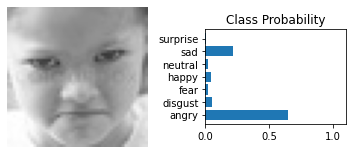

In [96]:
image, label = validset[8]
image = image.unsqueeze(0)

logits = model(image.to(DEVICE))
probs = nn.Softmax(dim = 1)(logits)

view_classify(image.squeeze(), probs)